# Learning Discriminatory Features of Birds and Cats: Triplet Network

## Table of Contents
* [Overview](#Overview)
* [Set the Environment](#Set-the-environment)
* [Build a Triplet Model](#Build-a-triplet-model)
* [Train the Model](#Train-the-model)
* [Deploy the Model](#Deploy-the-model)
* [Test the ASTORE Model](#Test-astore-model)
* [Conclusion](#Conclusion)

## Overview <a id="Overview"></a>
This example trains an embedding model created with a Triplet Network. The Triplet Network is trained using data created on-the-fly from images in a directory. A single branch of the Triplet Network is deployed as an embedding model for individual images. The deployed embedding model is verified using K-means clustering.

The data used for this example consists of a subset of images obtained from [Google's Open Image V4](https://arxiv.org/abs/1811.00982). To recreate this data set:
1. Remove all images that are not cat or bird
2. Remove images with multiple instances
3. Resize all remaining images to be 224 x 224 pixels.

The dataset contains 10680 training images and 3045 testing images
For training, 4606 images contain the Cat class while 6073 images for Bird
For testing, 1381 images contain Cat while 1664 images for Bird. 
The data is stored in the following directory structure.

../data <br/>
  |--train <br/>
  |  |--bird <br/>
  |  |  |--image1 <br/>
  |  |  |--image2 <br/>
  |  |  |--etc. <br/>
  |  |--cat <br/>
  |  |  |--image3 <br/>
  |  |  |--image4 <br/>
  |  |  |--etc. <br/>
  |--test <br/>
  |  |--bird <br/>
  |  |  |--image5 <br/>
  |  |  |--image6 <br/>
  |  |  |--etc. <br/>
  |  |--cat <br/>
  |  |  |--image7 <br/>
  |  |  |--image8 <br/>
  |  |  |--etc. <br/>
  |  |--/ <br/>
  |--/<br/>

## Set the Environment <a id="Set-the-environment"></a>

First, set notebook environment by doing the following:
1. Import relevant modules
2. Use matplotlib inline magic so plots render correctly
3. Start a CAS session

**Remember:** Change **`host_name`** and **`port_number`** to match your CAS server. You should also have an authinfo (authentication) file set up as well.

In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *
from dlpy.embedding_model import EmbeddingModel

In [4]:
s = CAS('host_name', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(userid)' is now the active caslib.


+ Elapsed: 0.00019s, user: 0.000129s, sys: 5e-05s, mem: 0.256mb

## Build a Triplet Model <a id="Build-a-triplet-model"></a>
A Triplet Network uses three copies of a neural network to learn discriminative features. We use ResNet18 as a base network for these three copies. Likewise, ResNet18 will serve as the base of our embedding, but in order to customize the embedding output, we add an embedding layer to ResNet18 that is also copied. 

We define our embedding layer to be a dense 4-neuron layer with an identity activation function. If this is not given, the last layer before the output layer will be used as the embedding layer.

The output features from each network are fed into an embedding loss layer to compute the triplet loss function. The triplet loss function is designed to minimize the Euclidean distance between the anchor image and the positive image and increase the distance between the anchor image and the negative image. Margin is used to tune how discriminative the features should be.

The resulting Triplet Network structure is stored in memory as the table "test_tr".

In [5]:
resnet18_model = ResNet18_Caffe(s,
                                width=224,
                                height=224
                                ,random_flip='HV',
                                random_mutation='random'
                                )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [6]:
embedding_layer = Dense(n=4, act='identity')
model_tr = EmbeddingModel.build_embedding_model(resnet18_model, model_table='test_tr',
                                              embedding_model_type='triplet', margin=-3.0,
                                              embedding_layer=embedding_layer)

NOTE: Convert the branch model into a functional model.
NOTE: Remove the task layers from the model.
NOTE: Model compiled successfully.


# Train the model <a id="Train-the-model"></a>
Generally, before training, we would need to create a training data set. We could do this easily with DLPy's ImageEmbeddingTable API or we could invoke CAS actions to craft the table manually as in <a href="https://go.documentation.sas.com/?docsetId=casdlpg&docsetTarget=p0rtwwco6lyoxhn1t2122nh99ldu.htm&docsetVersion=8.5&locale=en#p1ek9mpk0ctu4en1ez1yi52co425">the SAS documentation</a>. 

However, in this example, we avoid explicitly creating a training data set. Instead, we provide *model_tr.fit_embedding_model()* with a path to our training image directory. When we provide a path, we direct the fitting algorithm to create training data on-the-fly using images in the direcory. For the Triplet Network, each sample needs an anchor image, a positive image, a negative image, and all the data associated with each image (such as filename, label, size, etc.).

We begin by specifying a few standard training options such as our GPU devices and our optimizer. The training proceeds as follows:

1. Create a batch of **`n_samples`** samples.
2. Train on that batch for **`max_epochs`** epochs.
3. Repeat 1, 2 for **`max_iter`** iterations.

This returns a list containing a CASResult for each data iteration. You can use this list to investigate training history. Furthermore, a table called test_tr_weights is created in CAS to store the model weights.

**Remember:** Change **`path`** to the server-side directory that contains the training data.

In [7]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)

In [8]:
from dlpy.model import Optimizer, MomentumSolver, AdamSolver
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=4), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=8, reg_l2=0.0001)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [9]:
res = model_tr.fit_embedding_model(optimizer=optimizer, n_threads=4, gpu=gpu, seed=1234,record_seed=23435,
                                   path='/server-side/path/to/data', 
                                   n_samples=2048, max_iter=15, 
                                   resize_width=224, resize_height=224)

Note: data generation took 17.510989665985107 (s) at iteration 0
NOTE: Training from scratch.
NOTE: Using cloud.example.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       4.26 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001         0.07158      2.874    15.18
NOTE:  1        0.0001         -0.1355      3.165    10.32
NOTE:  2        0.0001         -0.2876      3.264    10.32
NOTE:  3        0.0001         -0.3277      3.053    10.32
NOTE:  4          1E-5          -0.567       3.37    10.32
NOTE:  5          1E-5         -0.6762      3.4

In [10]:
res[-1]

,Descr,Value
0,Model Name,test_tr
1,Model Type,Convolutional Neural Network
2,Number of Layers,163
3,Number of Input Layers,3
4,Number of Output Layers,0
5,Number of Convolutional Layers,63
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,3
8,Number of Batch Normalization Layers,63
9,Number of Residual Layers,24


## Deploy the model <a id="Deploy-the-model"></a>
We built and trained as three identical networks combined by an embedding loss layer. However, in practice, we want to be able to use the embedding model on a single image. To save only one branch of the model to ASTORE, we specify **`model_type='branch'`**. The embedding loss layer is removed and replaced by a generic output layer. Alternatively, if we did want to store the Triplet Network as a whole, we could specify **`model_type='full'`**.

The generated ASTORE file will be stored on the client as specified by **`path`**.

Note that even this branch model isn't quite a classification model. Though we create an embedding, the output layer isn't configured to produce anything useful. It merely outputs the features from the embedding layer. In our case, the embedding layer is densely connected and outputs four numbers. To make this a true classification model, replace the final output layer with a layer capable of classifying, like softmax.

**Remember:** Change **`path`** to the client-side directory where you'd like to store the astore model.

In [11]:
branch_model = model_tr.deploy_embedding_model(output_format='astore', model_type='branch', 
                                path=r'/client-side/path/to/save/astore')

NOTE: Model compiled successfully.
NOTE: Model weights attached successfully!
NOTE: Model astore file saved successfully.


In [12]:
branch_model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,InputLayer_0,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Convo.1,convo,"(7, 7)","(2, 2)",Identity,"(112, 112, 64)","(9408, 0)",118013952
2,2,B.N.1,batchnorm,,,Relu,"(112, 112, 64)","(0, 128)",0
3,3,Pool1,pool,"(3, 3)","(2, 2)",Max,"(56, 56, 64)","(0, 0)",0
4,4,R1C2,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
5,5,R1B2,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
6,6,R1C3,convo,"(3, 3)","(1, 1)",Identity,"(56, 56, 64)","(36864, 0)",115605504
7,7,R1B3,batchnorm,,,Relu,"(56, 56, 64)","(0, 128)",0
8,8,R1C0,convo,"(1, 1)","(1, 1)",Identity,"(56, 56, 64)","(4096, 0)",12845056
9,9,R1B0,batchnorm,,,Identity,"(56, 56, 64)","(0, 128)",0


## Test the ASTORE Model <a id="Test-astore-model"></a>
Now that we have an embedding model with a single branch, we can verify our results with a single image stream. If our embedding works well then we should have 2 clusters - one for birds and one for cats.

First we load the ASTORE Model.
Then we check the ASTORE information, noting that \_LayerAct_53_0_0_0 through \_LayerAct_53_0_0_3 are the components of the embedding vector. We create an ImageTable from the testing data directory. Using **`astore.score`**, we compute an embedding vector for each image and use the embedding vectors for K-means clustering. 

**Remember:** Inside **`open()`** change the path to the client-side path where you stored the astore file. Also, change **`path`** to the server-side directory with the testing data.

In [13]:
with open(r'/client-side/path/to/astore', mode='rb') as file: 
    fileContent = file.read()    
s.loadactionset('astore')
store_ = sw.blob(fileContent)
s.astore.upload(rstore=dict(name='test_tr_branch', replace=True),store = store_)

NOTE: Added action set 'astore'.
NOTE: 44793765 bytes were uploaded to the table "test_tr_branch" in the caslib "CASUSER(userid)".


+ Elapsed: 0.0687s, user: 0.0277s, sys: 0.0411s, mem: 87mb

We describe the astore model to make sure it loaded correctly.

In [14]:
s.astore.describe(rstore='test_tr_branch')

[Key]

 Store Key
 
                                         Key
 0  1C2FD2FA6322575B2F89BC9A8B778D4A867CAA13

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine           deeplearn
 1     Time Created  25Feb2020:14:34:10

[InputVariables]

 Input Variables
 
       Name     Length   Role       Type    RawType FormatName
 0  _image_  1000000.0  Input  Varbinary  Character           

[OutputVariables]

 Output Variables
 
                   Name  Length       Type                              Label
 0      P__fake_output_     8.0        Num           Predicted: _fake_output_
 1      I__fake_output_    12.0  Character                Into: _fake_output_
 2  _LayerAct_53_0_0_0_     8.0        Num  Output for Layer embeddinglayer_0
 3  _LayerAct_53_0_0_1_     8.0        Num  Output for Layer embeddinglayer_0
 4  _LayerAct_53_0_0_2_     8.0        Num  Output for Layer embeddinglayer_0
 5  _LayerAct_53_0_0_3_     8.0        Num  Output for Layer embeddinglayer_0

+ Elapsed: 1.29s, user: 1.18s, sys: 0.0867s, mem: 197mb

We use the ImageTable API to load images from a server-side path into CAS. We list the frequency of each class and show a few images to ensure that the data we loaded matches our expectations.

In [15]:
my_test_table = ImageTable.load_files(conn=s, path='/server-side/path/to/test/data')

In [16]:
my_test_table.label_freq

,Level,Frequency
Bird,1,1664
Cat,2,1381


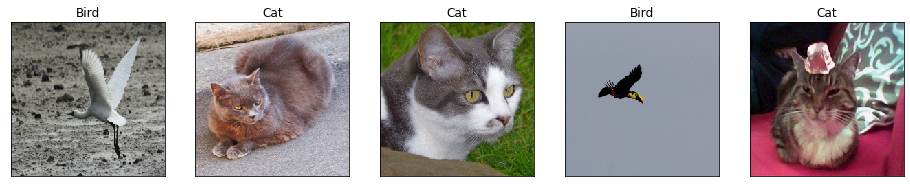

In [17]:
my_test_table.show(randomize=True)

When the model scores each observation, it reads an image and returns a vector of four numbers that represent that image's embedding. We store each embedding in a CAS Table named astore_score1_branch_gpu. The components of the vector are CAS table columns with names: '_LayerAct_53_0_0_0_', '_LayerAct_53_0_0_0_', '_LayerAct_53_0_0_1_', '_LayerAct_53_0_0_2_'.

In [18]:
s.score(rstore = 'test_tr_branch',
        table = my_test_table,
        nthreads =1,
        copyvars=['_filename_0', '_label_'],
        options=[dict(name='usegpu', value='1'),
                 dict(name='NDEVICES', value='1'), 
                 dict(name='DEVICE0', value='0')
                ],
        out = dict(name='astore_score1_branch_gpu', replace=True))

[OutputCasTables]

             casLib                      Name  Rows  Columns  \
 0  CASUSER(userid)  astore_score1_branch_gpu  3045        8   
 
                                                          casTable  
 0  CASTable('astore_score1_branch_gpu', caslib='CASUSER(userid)')  

[Timing]

 Task Timing
 
                  Task    Seconds   Percent
 0   Loading the Store   0.000434  0.000035
 1  Creating the State   2.409450  0.192306
 2             Scoring  10.119178  0.807643
 3               Total  12.529271  1.000000

+ Elapsed: 13.2s, user: 10.3s, sys: 2.52s, mem: 286mb

In [19]:
s.fetch(table='astore_score1_branch_gpu', 
        fetchVars=['_LayerAct_53_0_0_0_', '_LayerAct_53_0_0_0_', 
                   '_LayerAct_53_0_0_1_', '_LayerAct_53_0_0_2_'],
                   to=5)

,_LayerAct_53_0_0_0_,_LayerAct_53_0_0_0_2,_LayerAct_53_0_0_1_,_LayerAct_53_0_0_2_
0,-1.042807,-1.042807,-0.193470,0.856849
1,-1.631085,-1.631085,-1.147002,0.386947
2,2.316453,2.316453,-2.651983,-1.665800
3,1.034859,1.034859,-1.551757,-1.590973
4,-1.417596,-1.417596,-0.700181,0.744398


To clean up the action parameters for clustering, we create a feature_list variable that we can pass to the kclus action.

In [20]:
feature_list=[]
for i in range(0, 4):
    feature_list.append("_LayerAct_53_0_0_" + str(i) +"_")

We input the feature_list into the kclus action to see how well our embedding grouped the dog breeds. The output tables show several facets of the model including observations used, model information, and cluster statistics. To assess the embedding, we will focus on the cluster summary.

A good embedding would result in low intracluster variance (all data points of a cluster are near the cluster center) and high intercluster variance (the distance between cluster centers is large). The distance between centroids is a good measure of intercluster variance. The remaining statistics in the cluster summary evaluate the intracluster distance. 

In [21]:
s.loadactionset('clustering')
s.kclus(table=dict(name='astore_score1_branch_gpu'),
        maxClusters=2, maxIters=100, standardize='std',
        inputs=feature_list,
        output=dict(casout=dict(name='cluster_results', replace=True),
                   copyvars=['_filename_0', '_label_']))

NOTE: Added action set 'clustering'.
NOTE: Using SEED=2050010885.
NOTE: Running for input data for K 2.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


[outputSize]

 {'outputNObs': 3045.0, 'outputNVars': 5}

[NObs]

 Number of Observations
 
                           Type       N
 0  Number of Observations Read  3045.0
 1  Number of Observations Used  3045.0

[ModelInfo]

 Model Information
 
                              RowId                        Parameter  \
 0             Clustering_Algorithm             Clustering Algorithm   
 1               Maximum_Iterations               Maximum Iterations   
 2                   Stop_Criterion                   Stop Criterion   
 3             Stop_Criterion_Value             Stop Criterion Value   
 4                         Clusters                         Clusters   
 5                   Initialization                   Initialization   
 6                             Seed                             Seed   
 7  Distance_For_Interval_Variables  Distance for Interval Variables   
 8                  Standardization                  Standardization   
 9              Interval_Imputation              Interval Imputation   
 
           Setting  
 0         K-means  
 1             100  
 2  Cluster Change  
 3               0  
 4               2  
 5           Forgy  
 6      2050010885  
 7       Euclidean  
 8             Std  
 9            None  

[DescStats]

 Descriptive Statistics
 
               Variable      Mean    StdDev
 0  _LayerAct_53_0_0_0_  0.231291  1.470494
 1  _LayerAct_53_0_0_1_ -1.474208  0.692470
 2  _LayerAct_53_0_0_2_ -0.609620  1.001417
 3  _LayerAct_53_0_0_3_  0.394356  0.603375

[WithinClusStats]

 Within Cluster Statistics
 
               Variable  Cluster      Mean    StdDev
 0  _LayerAct_53_0_0_0_        1 -0.879961  0.437517
 1                             2  0.859962  0.541850
 2  _LayerAct_53_0_0_1_        1  0.716544  0.590573
 3                             2 -0.700259  0.802676
 4  _LayerAct_53_0_0_2_        1  0.876011  0.516709
 5                             2 -0.856102  0.482870
 6  _LayerAct_53_0_0_3_        1 -0.557885  0.897057
 7                             2  0.545205  0.767916

[Standardization]

 Standardization
 
               Variable  Location     Scale
 0  _LayerAct_53_0_0_0_  0.231291  1.470494
 1  _LayerAct_53_0_0_1_ -1.474208  0.692470
 2  _LayerAct_53_0_0_2_ -0.609620  1.001417
 3  _LayerAct_53_0_0_3_  0.394356  0.603375

[ClusterSum]

 Cluster Summary
 
    Cluster  Frequency   MinDist   MaxDist   AvgDist          SSE  \
 0        1     1505.0  0.096503  4.376008  1.131094  2424.293582   
 1        2     1540.0  0.059447  4.639420  1.189301  2709.792293   
 
    StdDeviation  NearestClus  DBtwCentroids  
 0      1.269183          2.0       3.041658  
 1      1.326501          1.0       3.041658  

[ClusterCenters]

 Cluster Centroids
 
    _ITERATION_  _CLUSTER_ID_  _LayerAct_53_0_0_0_  _LayerAct_53_0_0_1_  \
 0          5.0           1.0            -1.062685            -0.978023   
 1          5.0           2.0             1.495860            -1.959116   
 
    _LayerAct_53_0_0_2_  _LayerAct_53_0_0_3_  S__LayerAct_53_0_0_0_  \
 0             0.267632             0.057742              -0.879961   
 1            -1.466934             0.723319               0.859962   
 
    S__LayerAct_53_0_0_1_  S__LayerAct_53_0_0_2_  S__LayerAct_53_0_0_3_  
 0               0.716544               0.876011              -0.557885  
 1              -0.700259              -0.856102               0.545205  

[IterStats]

 Iteration History
 
    IterationNum  IterationSSE    SSEChange  StopCriterion
 0             0  12982.864337          NaN            NaN
 1             1   5965.456870 -7017.407467      14.449918
 2             2   5147.088101  -818.368769       2.036125
 3             3   5134.725857   -12.362244       0.361248
 4             4   5134.111839    -0.614018       0.065681
 5             5   5134.085876    -0.025963       0.000000

[OutputCasTables]

             casLib             Name Label  Rows  Columns  \
 0  CASUSER(userid)  cluster_results        3045        5   
 
    

We have looked already at the quality of clusters, but not what the clusters are composed of. Here, we want to verify that each cluster corresponds to either birds or dogs. We do this by determining the frequency of labels, grouping by clusters.

In [22]:
s.freq(table=dict(name='cluster_results', groupby='_cluster_id_'), inputs='_label_')

[ByGroupInfo]

 ByGroupInfo
 
    _CLUSTER_ID_ _CLUSTER_ID__f         _key_
 0           1.0              1             1
 1           2.0              2             2

[ByGroup1.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column CharVar FmtVar  Level  Frequency
 _CLUSTER_ID_                                          
 1             _label_    Bird   Bird      1      251.0
 1             _label_     Cat    Cat      2     1254.0

[ByGroup2.Frequency]

 Frequency for CLUSTER_RESULTS
 
                Column CharVar FmtVar  Level  Frequency
 _CLUSTER_ID_                                          
 2             _label_    Bird   Bird      1     1413.0
 2             _label_     Cat    Cat      2      127.0

+ Elapsed: 0.00892s, user: 0.00614s, sys: 0.00719s, mem: 8.26mb

## Conclusion <a id="Conclusion"></a>
Althogh some birds are embedded among cats and vice-versa, we end up with 2 decent clusters using a vector with 4 numbers. Each cluster is dominated by a single class. 

In [23]:
s.endsession()

+ Elapsed: 0.000158s, user: 0.000138s, mem: 0.204mb